In [1]:
# %%
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras.utils as image
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from tensorflow.keras.optimizers import AdamW
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/tmp/ipykernel_3781055/3714227907.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-30 21:54:23.694415: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 21:54:23.774833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 21:

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
train_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/train'
test_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/test'
val_dir = '/home/btech/2021/abhishek.kumar21b/malware_detection/malimg_dataset/val'

In [3]:
image_size=(224,224,3)
batch_size=32

In [4]:
# %%
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# Load training and test images
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)
val_images, val_labels = load_images(val_dir)


# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
train_datagen.fit(train_images)


In [7]:
train_images.shape

(7459, 224, 224, 3)

In [8]:
print(train_labels)

[ 0  0  0 ... 24 24 24]


In [9]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=image_size)
for layer in base_model.layers[:-5]:  # Fine-tune top 5 layers
    layer.trainable = False

2024-04-30 21:55:46.093259: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-30 21:55:46.093362: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: AI-iiitg
2024-04-30 21:55:46.093380: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: AI-iiitg
2024-04-30 21:55:46.093630: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 545.23.8
2024-04-30 21:55:46.093681: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.23.8
2024-04-30 21:55:46.093692: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 545.23.8


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
predictions = Dense(25, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with AdamW optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer=AdamW(learning_rate=1e-4), metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [12]:
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=50,  # Adjust as needed
    validation_data=(val_images, val_labels),  # If using a validation set
    callbacks=[early_stopping]
)


Epoch 1/50
234/234 [==============================] - 333s 1s/step - loss: 9.9744 - accuracy: 0.7599 - val_loss: 8.6809 - val_accuracy: 0.6999
Epoch 2/50
234/234 [==============================] - 325s 1s/step - loss: 7.2408 - accuracy: 0.9035 - val_loss: 6.3905 - val_accuracy: 0.8732
Epoch 3/50
234/234 [==============================] - 422s 2s/step - loss: 5.4594 - accuracy: 0.9200 - val_loss: 5.1456 - val_accuracy: 0.7476
Epoch 4/50
234/234 [==============================] - 315s 1s/step - loss: 4.1317 - accuracy: 0.9348 - val_loss: 3.7777 - val_accuracy: 0.8754
Epoch 5/50
234/234 [==============================] - 372s 2s/step - loss: 3.1289 - accuracy: 0.9465 - val_loss: 2.8215 - val_accuracy: 0.9025
Epoch 6/50
234/234 [==============================] - 344s 1s/step - loss: 2.3590 - accuracy: 0.9487 - val_loss: 2.1155 - val_accuracy: 0.9339
Epoch 7/50
234/234 [==============================] - 340s 1s/step - loss: 1.7798 - accuracy: 0.9500 - val_loss: 1.9272 - val_accuracy: 0.7757

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [14]:
# Train the model (adjust epochs and batch size as needed)
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/10
 43/234 [====>.........................] - ETA: 2:45 - loss: 0.1998 - accuracy: 0.9637

234/234 [==============================] - 236s 1s/step - loss: 0.1556 - accuracy: 0.9713 - val_loss: 0.1114 - val_accuracy: 0.9848
Epoch 2/10
234/234 [==============================] - 237s 1s/step - loss: 0.1182 - accuracy: 0.9846 - val_loss: 0.0934 - val_accuracy: 0.9870
Epoch 3/10
234/234 [==============================] - 232s 991ms/step - loss: 0.0948 - accuracy: 0.9887 - val_loss: 0.0823 - val_accuracy: 0.9870
Epoch 4/10
234/234 [==============================] - 235s 1s/step - loss: 0.0900 - accuracy: 0.9882 - val_loss: 0.0751 - val_accuracy: 0.9881
Epoch 5/10
234/234 [==============================] - 239s 1s/step - loss: 0.0714 - accuracy: 0.9928 - val_loss: 0.0718 - val_accuracy: 0.9881
Epoch 6/10
234/234 [==============================] - 233s 993ms/step - loss: 0.0632 - accuracy: 0.9942 - val_loss: 0.0634 - val_accuracy: 0.9913
Epoch 7/10
234/234 [==============================] - 235s 1s/step - loss: 0.0587 - accuracy: 0.9953 - val_loss: 0.0727 - val_accuracy: 0.9870
Epoc

In [15]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [16]:
# Extract features using the model without the top layer in batches
# Get the penultimate layer's output
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)


batch_size=32
# Use the extract_features function to process images in batches
train_features = extract_features(feature_extractor, train_images, batch_size)
test_features = extract_features(feature_extractor, test_images, batch_size)

print("Shape of extracted train features:", train_features.shape)
print("Shape of extracted test features:", test_features.shape)

1/1 [==============================] - 1s 915ms/step


1/1 [==============================] - 1s 943ms/step
Shape of extracted train features: (7459, 1024)
Shape of extracted test features: (957, 1024)


In [17]:
# %%
# Define the parameter grid for Naive Bayes
nb_param_grid = {}  # No hyperparameters for Gaussian Naive Bayes

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Use GridSearchCV to find the best parameters for Naive Bayes
nb_grid_search = GridSearchCV(nb_classifier, nb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
nb_grid_search.fit(train_features, train_labels)

# Get the best parameters for Naive Bayes
best_nb_params = nb_grid_search.best_params_

# Use the best parameters to train the final Naive Bayes model
final_nb_classifier = GaussianNB(**best_nb_params)
start_time_nb = time.time()
final_nb_classifier.fit(train_features, train_labels)
train_time_nb = time.time() - start_time_nb

# Predict labels for the test set using Naive Bayes
nb_predictions = final_nb_classifier.predict(test_features)

# Evaluate accuracy for Naive Bayes
nb_accuracy = accuracy_score(test_labels, nb_predictions)
print("\nBest Naive Bayes Parameters:", best_nb_params)
print("Naive Bayes Accuracy:", nb_accuracy)


Best Naive Bayes Parameters: {}
Naive Bayes Accuracy: 0.9916405433646813


In [18]:
# Additional evaluation metrics for Naive Bayes
precision_nb = precision_score(test_labels, nb_predictions, average='weighted')
recall_nb = recall_score(test_labels, nb_predictions, average='weighted')
f1_nb = f1_score(test_labels, nb_predictions, average='weighted')

print("Train Time (sec) Naive Bayes:", train_time_nb)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time_nb = nb_grid_search.cv_results_['mean_fit_time'][nb_grid_search.best_index_]
print("Train Time (sec) Grid Naive Bayes:", grid_train_time_nb)

# Calculate Matthews Correlation Coefficient (MCC) for Naive Bayes
mcc_nb = matthews_corrcoef(test_labels, nb_predictions)
print("Matthews Correlation Coefficient (MCC) Naive Bayes:", mcc_nb)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = nb_grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)


Train Time (sec) Naive Bayes: 0.3633148670196533
Train Time (sec) Grid Naive Bayes: 0.2810065746307373
Matthews Correlation Coefficient (MCC) Naive Bayes: 0.9902656706014472
Optimization Algorithm Accuracy: 0.9949055010969888


In [19]:

# Confusion matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(test_labels, nb_predictions)
precision_nb = precision_score(test_labels, nb_predictions, average='weighted')

FP_nb = conf_matrix_nb.sum(axis=0) - np.diag(conf_matrix_nb)  
FN_nb = conf_matrix_nb.sum(axis=1) - np.diag(conf_matrix_nb)
TP_nb = np.diag(conf_matrix_nb)
TN_nb = conf_matrix_nb.sum()

In [20]:

# %%
# Display results for Naive Bayes
print("\nResults for Naive Bayes:")
print("Precision (Naive Bayes):", precision_nb)
print("Recall (Naive Bayes):", recall_nb)
print("F1 Score (Naive Bayes):", f1_nb)
print("True Positive Rate (TPR) (Naive Bayes):", np.mean(TP_nb / (TP_nb + FN_nb)))
print("True Negative Rate (TNR) (Naive Bayes):", np.mean(TN_nb / (TN_nb + FP_nb)))
print("False Positive Rate (FPR) (Naive Bayes):", np.mean(FP_nb / (FP_nb + TN_nb)))
print("False Negative Rate (FNR) (Naive Bayes):", np.mean(FN_nb / (TP_nb + FN_nb)))

print("False Discovery Rate (FDR) (Decision Tree):", np.mean(FP_nb / (FP_nb + TP_nb)))
print("False Omission Rate (FOR) (Decision Tree):", np.mean(FN_nb / (FN_nb + TN_nb)))
print("Matthews Correlation Coefficient (MCC) (Naive Bayes):", mcc_nb)



Results for Naive Bayes:
Precision (Naive Bayes): 0.9918656219681183
Recall (Naive Bayes): 0.9916405433646813
F1 Score (Naive Bayes): 0.9916107498000124
True Positive Rate (TPR) (Naive Bayes): 0.9808399051928464
True Negative Rate (TNR) (Naive Bayes): 0.99966614492741
False Positive Rate (FPR) (Naive Bayes): 0.00033385507258996733
False Negative Rate (FNR) (Naive Bayes): 0.01916009480715363
False Discovery Rate (FDR) (Decision Tree): 0.016039696363255515
False Omission Rate (FOR) (Decision Tree): 0.00033385507258996733
Matthews Correlation Coefficient (MCC) (Naive Bayes): 0.9902656706014472


In [21]:
conf_matrix_nb

array([[ 12,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  19,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  16,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  19,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  16,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      

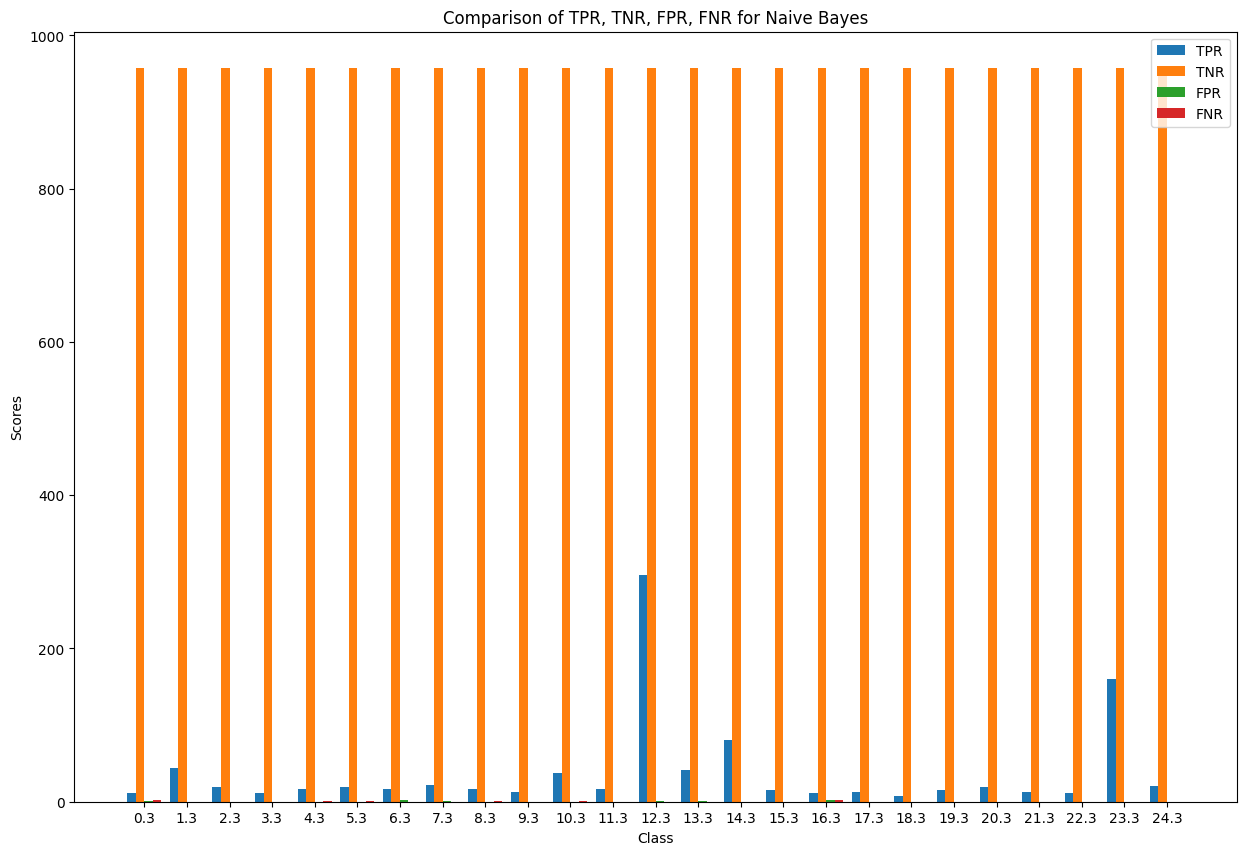

In [22]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP_nb, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_nb, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_nb, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_nb, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for Naive Bayes')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

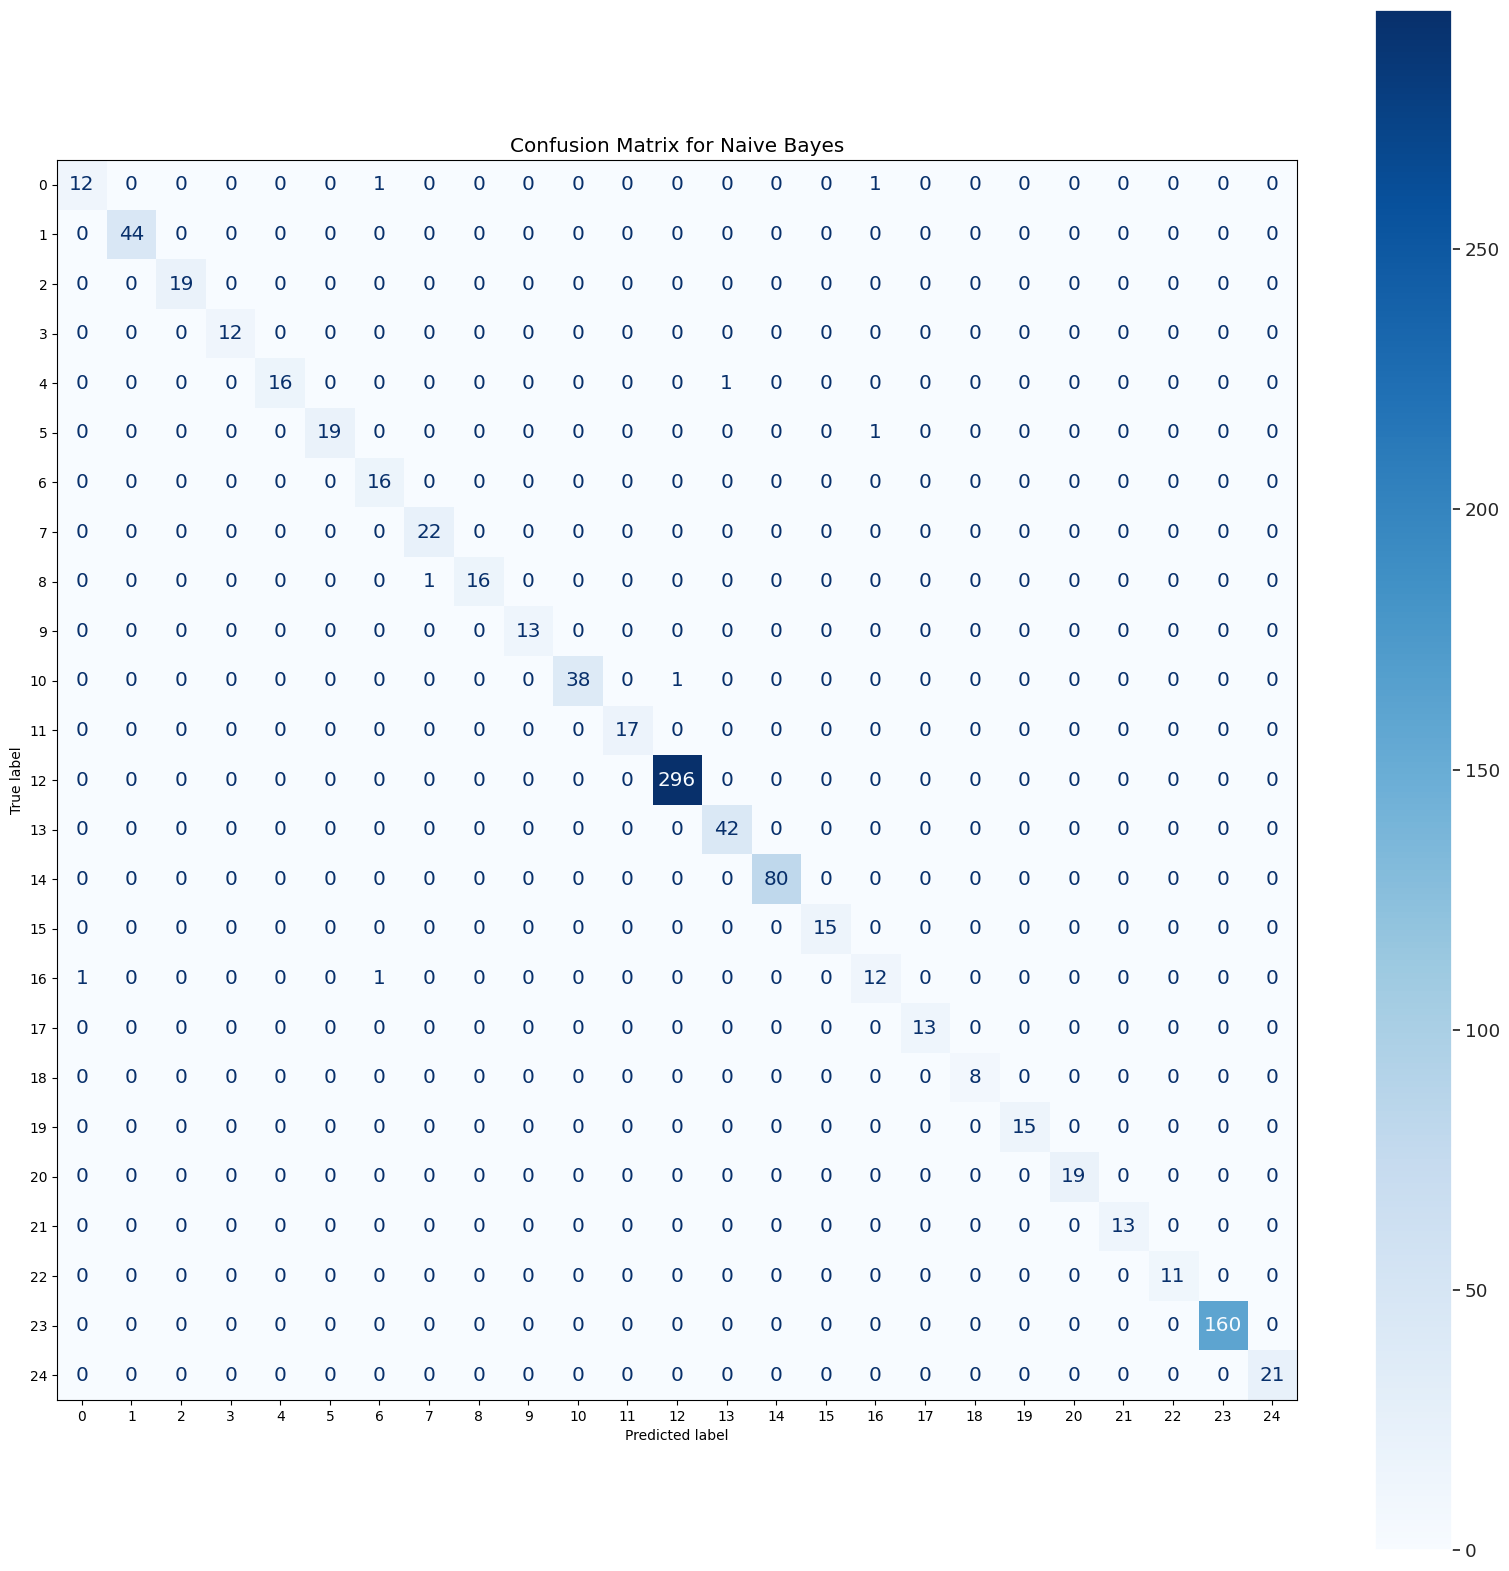

In [23]:
# Plot Confusion Matrix for Naive Bayes
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_nb, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()